# 1D ladder, some theory and practice

In this tutorial, we take the 1D chain one step further and investigate a 1D ladder. We now think about $M$ layers with $N$ sites, where the wavefunction for layer $m$ is given by
$$
\psi^{(m)}(y) = \sum_{i=1}^{N} c_i^m \phi_i^m(y)
$$
Similar to the 1D chain, we have 3 regions we must piece together: left lead, nanojunction, and right lead. In the left lead, we have the Schrödinger equation
$$
\left\{-\frac{\hbar^2}{2m}\partial_y^2 + V(y)\right\}\psi^{(m)} = E\psi^{(m)}
$$
which after being discretized becomes
$$
-\frac{\hbar^2}{2m\Delta^2}(\psi_{n+1}^{(m)} - 2 \psi_{n}^{(m)} + \psi_{n-1}^{(m)}) + v_n\psi_n^{(m)} = E\psi_n^{(m)}
$$
which is exactly the same as the 1D chain, except we now have $M$ layers to solve for. We then end up with an infinite matrix that looks like 
\begin{equation}
\begin{pmatrix}
\ddots & \ddots         & \ddots       & 0         & 0      & 0       & 0 \\
0 & B_{(m-1)}^{\dagger} & H_{(m)}          & B_{(m)}        & 0       & 0      & 0 \\
0 & 0        & B_{(m)}^{\dagger} & H_{(m+1)}          & B_{(m+1)} & 0      & 0 \\
0 & 0        & 0       & B_{(m+1)}^{\dagger} & H_{(m+2)}          & B_{(m+2)} & 0\\
0 & 0         & 0       & 0          & \ddots       & \ddots       & \ddots 
\end{pmatrix}
\begin{pmatrix}
\vdots\\
{\bf c}^{(m)}\\
{\bf c}^{(m+1)}\\
{\bf c}^{(m+2)}\\
\vdots
\end{pmatrix}
=
E{\bf I}
\begin{pmatrix}
\vdots\\
{\bf c}^{(m)}\\
{\bf c}^{(m+1)}\\
{\bf c}^{(m+2)}\\
\vdots
\end{pmatrix}
\end{equation}
when we only consider nearest neighbour interactions. We must then solve the equations 
\begin{eqnarray}
-B_{(m-1)}^{\dagger} {\bf c}^{(m-1)} + (E{\bf I} - H^{(m)}) {\bf c}^{(m)} - B^{(m+1)}{\bf c}^{(m+1)} = E{\bf c}^{(m)}
\end{eqnarray}
Again, we exploit the 

In [5]:
import kwant 
# For plotting
from matplotlib import pyplot
import numpy as np
%matplotlib inline

In [86]:
def make_system(a=1, t=1.0, W=16, L=16):
    # Start with an empty tight-binding system and a single square lattice. 
    # `a` is the lattice constant (by default set to 1 for simplicity.
    lat = kwant.lattice.square(a, norbs=1)

    syst = kwant.Builder()

    syst[(lat(x, y) for x in range(L) for y in range(W))] = 4 * t

    syst[lat.neighbors()] = -t

    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    lead[(lat(0, j) for j in range(W))] = 4 * t
    lead[lat.neighbors()] = -t
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    return syst

/Users/b295319/anaconda3/lib/python3.6/site-packages/kwant/linalg/lll.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs = np.linalg.lstsq(vecs_orig.T, vecs.T)[0]
/Users/b295319/anaconda3/lib/python3.6/site-packages/kwant/linalg/lll.py:144: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  center_coords = np.array(np.round(np.linalg.lstsq(basis.T, vec)[0]), int)


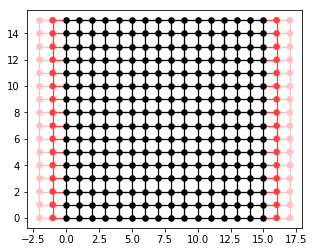

In [87]:
syst = make_system()
# Check that the system looks as intended.
kwant.plot(syst)
# Finalize the system.
syst = syst.finalized()

Total number of states: 2260.13201080527


Text(0.5,0,'Density of states [Arbitrary units]')

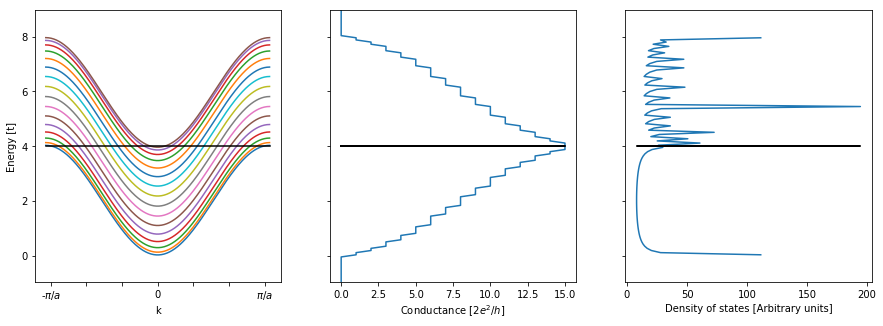

In [88]:
def conductance(syst, energies):
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(0, 1))
    return data
    

density = kwant.operator.Density(syst)

energies, doss = [], []
for e in np.linspace(-10.0, 10.0, 256):
    try:
        wf = kwant.wave_function(syst, energy=e)(0)
        dos = density(wf[0])
        energies.append(e)
        doss.append(np.sum(dos))
#         pyplot.plot(np.absolute(wf))
#         pyplot.show()
    except:
        pass

e = np.linspace(-10,10,256)
cond = conductance(syst, energies=e)
fig, axes = pyplot.subplots(1,3, figsize=(15,5), sharey='row')

kwant.plotter.bands(syst.leads[0], momenta=np.linspace(-np.pi,  np.pi, 256), show=False, ax=axes[0])
axes[1].plot(cond, e)
axes[2].plot(doss, energies)

e_fermi = np.ones(256) * 4.
axes[0].plot(np.linspace(-np.pi,  np.pi, 256), e_fermi, color='k')
axes[1].plot(cond, e_fermi, color='k')
axes[2].plot(doss, np.ones_like(energies) * 4.0, color='k')

print('Total number of states:', np.sum(doss))

axes[0].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[1].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[2].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[0].set_xlabel('k')
axes[0].set_ylabel('Energy [t]')
pyplot.sca(axes[0])
pyplot.xticks(range(-3,4), ['-$\pi / a$', '', '', 0, '', '', '$\pi / a$'])

axes[1].set_xlabel('Conductance [$2e^2 / h$]')
axes[2].set_xlabel('Density of states [Arbitrary units]')

Text(0,0.5,'Current [2e / h]')

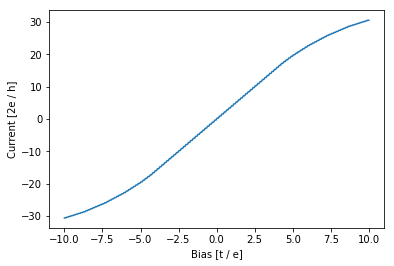

In [85]:
kB = 1.0
T = 0.001
def fermi(E, mu):
    return 1. / (np.exp((E - mu) / (kB * T)) + 1.)

vec_fermi = np.vectorize(fermi)

bias = np.linspace(-10.0, 10.0, 256)
V, I = [], []
for i, val in enumerate(bias):
    mu_left = val / 2.0 + 2. 
    mu_right = -val / 2.0 + 2.
    diff = vec_fermi(e, mu_left) - vec_fermi(e, mu_right)
    current = (e[1] - e[0]) * np.sum(cond * diff) 
    I.append(current)
    
pyplot.plot(bias, I)
pyplot.xlabel('Bias [t / e]')
pyplot.ylabel('Current [2e / h]')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
%matplotlib inline

E = 0.
n_modes = 5
for E in np.linspace(0., 10., 32):
    H = np.matrix(np.eye(n_modes) * 2.)
    V = np.matrix(np.eye(n_modes) * -1.)
    zs = np.zeros((n_modes, n_modes))
    os = np.eye(n_modes)
    top = np.hstack((zs, os))
    bottom = np.hstack((-V, os* E - H))
    p1 = np.vstack((top, bottom))
    p2 = np.vstack((np.hstack((os, zs)), np.hstack((zs, V.H))))
    eigs, vecs = eig(p1, p2)
    counts = {'imag-': 0, 'imag+': 0, 'real-': 0, 'real+': 0}
    for k in np.log(eigs):
        if np.imag(k) == 0.:
            if np.real(k) > 0.:
                counts['real+'] += 1
            elif np.real(k) < 0.:
                counts['real-'] += 1
        else:
            if np.imag(k) > 0.:
                counts['imag+'] += 1
            elif np.imag(k) < 0.:
                counts['imag-'] += 1

    print(E, counts)
#     wfs = []
#     for i in range(n_modes):
#         wfs.append(vecs[:n_modes, i])
#     a = []
#     for wf1 in wfs:
#         b = []
#         for wf2 in wfs: 
#             b.append(np.vdot(wf1, wf2))
#         a.append(b)

    # print(np.real(np.array(a)))
#     plt.imshow(np.real(np.array(a)))
#     plt.colorbar()